# Model Interpretation for Pretrained Deep Learning Models

This notebook applies model interpretability algorithms on pretrained deep learning models (in this case ResNet 50 or 101), using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are 
`Integrated Gradients` (w/ and w/o noise tunnel),  
`GradientShap`, `Occlusion`,
`LRP`. 
A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.

  **Note:** Before running, install torchvision, PIL, matplotlib.

In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule
import pandas as pd

from CNN_classifier.cub import cub200
from CNN_classifier.models.models_for_cub import ResNet


/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/trial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1- Loading the model and the dataset


Loads the Resnet model we trained on CUB and sets it to eval mode 

**Note**: modify the path to the saved models in cell [8] line 8 and the path to the saved dataset in cell [9] line 2

In [3]:
# Initialize ResNet-50 for CUB-200-2011
model = ResNet(pre_trained=False, n_class=200, model_choice=50)

# Load the trained weights (update the path to your actual saved model)
# Load the trained weights
checkpoint_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/model_save1/ResNet/ResNet50.pkl"  # Replace with your model's file path
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Remove `module.` prefix if present in the keys
if any(key.startswith("module.") for key in state_dict.keys()):
    state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

# Load the state_dict into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model = model.eval()

print("Loaded ResNet-50 trained on CUB-200-2011.")



/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/trial/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/trial/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_29383/716021257.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details)

Loaded ResNet-50 trained on CUB-200-2011.


Please modify the classes_file_path with the path to the classes contained int CUB_200_2011/classes.txt

In [4]:
# Define the path to the classes.txt file
classes_file_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/CUB_200_2011/classes.txt"  # Update to actual path

# Load the CUB-200-2011 class labels into a dictionary
idx_to_labels = {}
with open(classes_file_path, "r") as file:
    for line in file:
        class_id, class_name = line.strip().split(" ")
        idx_to_labels[int(class_id) - 1] = class_name  # Adjust for 0-based indexing

# Print a few labels to verify
print(f"Loaded {len(idx_to_labels)} class labels for CUB-200-2011.")
print(f"Sample labels: {list(idx_to_labels.items())[:5]}")

Loaded 200 class labels for CUB-200-2011.
Sample labels: [(0, '001.Black_footed_Albatross'), (1, '002.Laysan_Albatross'), (2, '003.Sooty_Albatross'), (3, '004.Groove_billed_Ani'), (4, '005.Crested_Auklet')]


Define transformers and normalizing functions for the image.
Then it also loads an image from the CUB folder that will be used for interpretation purposes.      
Please add a path in image_path to a photo in the dataset (CUB_200_2011/images/selected_pic)

In [8]:
transform = transforms.Compose([
 transforms.Resize(448), #modified from 226 in the original code
 transforms.CenterCrop(448), #modified from 226 in the original code
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

image_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/CUB_200_2011/images/048.European_Goldfinch/European_Goldfinch_0003_33066.jpg"
img = Image.open(image_path).convert("RGB")

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

print(f"Input tensor shape: {input.shape}") #added final check

Input tensor shape: torch.Size([1, 3, 448, 448])


Predict the class of the input image

In [9]:
# Pass the input through the model
output = model(input)

# Apply softmax to get class probabilities
output = F.softmax(output, dim=1)

# Get the highest prediction score and its index
prediction_score, pred_label_idx = torch.topk(output, 1)

# Convert the index to a label
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[pred_label_idx.item()]  # Use idx_to_labels loaded from classes.txt

# Print the result
print(f'Predicted: {predicted_label} (Confidence: {prediction_score.squeeze().item():.4f})')


Predicted: 048.European_Goldfinch (Confidence: 0.9998)


## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [10]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: 048.European_Goldfinch ( 0.999800980091095 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

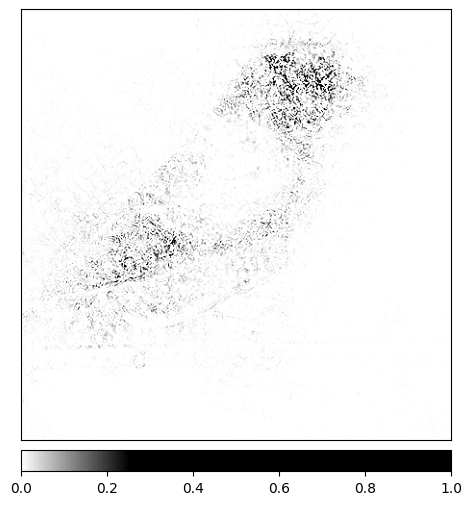

In [11]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

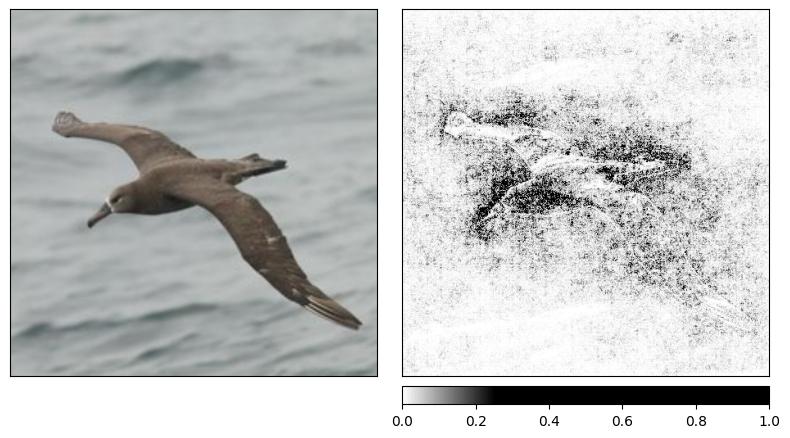

In [34]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## 3- Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [35]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

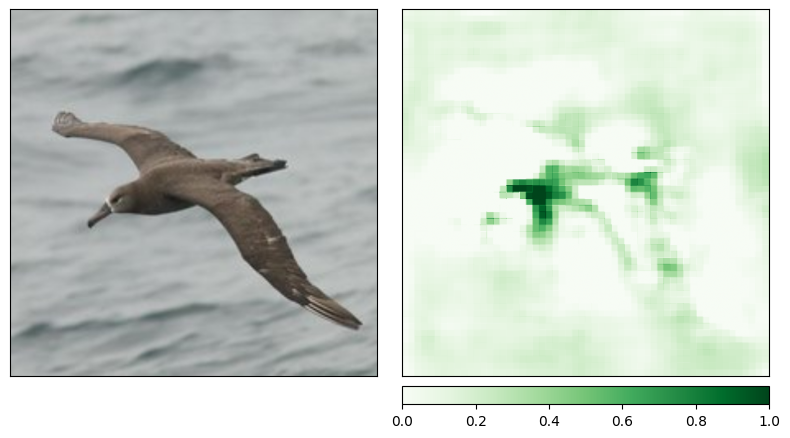

In [36]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)


The upper part of the bird, especially the beak, seems to be the most critical for the model to predict this class.

We can verify this further by occluding the image using a larger sliding window:

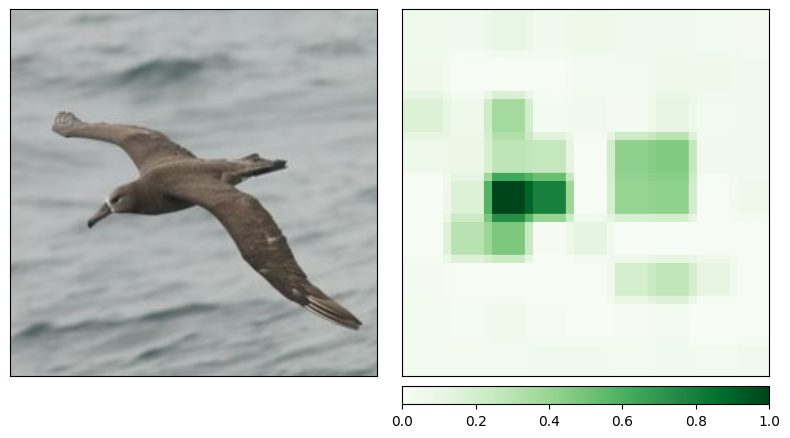

In [37]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

 ## 4- LRP-based attribution

Now let's try a different approach called Layer-Wise Relevance Propagation (LRP). It uses a backward propagation mechanism applied sequentially to 
all layers of the model, to see which neurons contributed to the output. The output score of LRP represents the relevance, decomposed into values for each layer. 
The decomposition is defined by rules that may vary for each layer. 

Initially, we apply a direct implementation of LRP attribution. The default Epsilon-Rule is used for each layer. 

Note: We use the VGG16 model instead here since the default rules for LRP are not fine-tuned for ResNet currently.

In [38]:
model = models.vgg16(pretrained=True)
model.eval()
lrp = LRP(model)

attributions_lrp = lrp.attribute(input, 
                                target=pred_label_idx)

/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/trial/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/trial/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/trial/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

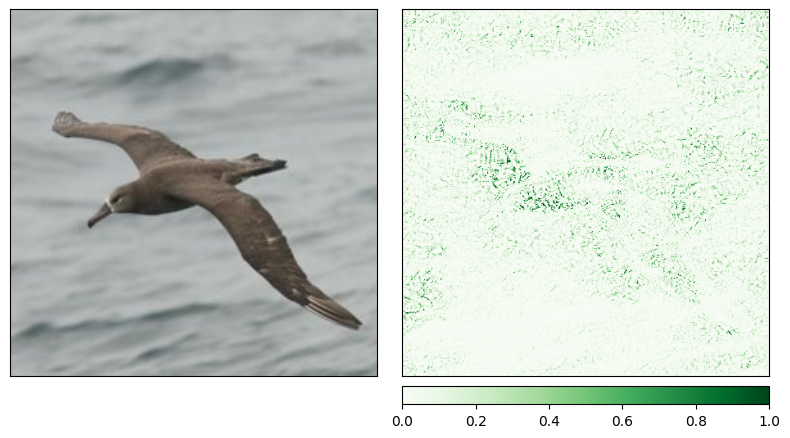

In [39]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

Now let's play around with changing the propagation rules for the various layers. This is a crucial step to get expressive heatmaps. Captum currently has the following propagation rules implemented: LRP-Epsilon, LRP-0, LRP-Gamma, LRP-Alpha-Beta, and the Identity-Rule. 

In the next steps, we list all the layers of VGG16 and assign a rule to each one. 

Note: Reference for recommmendations on how to set the rules can be found in *[Towards best practice in explaining neural network decisions with LRP](https://arxiv.org/abs/1910.09840)*.

In [40]:
layers = list(model._modules["features"]) + list(model._modules["classifier"])
num_layers = len(layers)

for idx_layer in range(1, num_layers):
    if idx_layer <= 16:
        setattr(layers[idx_layer], "rule", GammaRule())
    elif 17 <= idx_layer <= 30:
        setattr(layers[idx_layer], "rule", EpsilonRule())
    elif idx_layer >= 31:
        setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0))

lrp = LRP(model)
attributions_lrp = lrp.attribute(input, 
                                target=pred_label_idx)

/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/trial/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Let us visualize the new attribution. As we can see in the generated output image, the heatmap shows clearly positive attributions forthe beak of the swan.

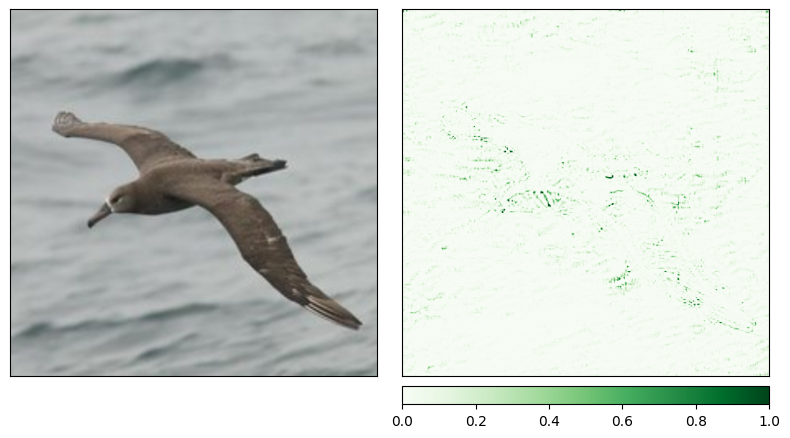

In [41]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)